# This Notebook is to Experiment LangGraph Agents

The Sequential Tasks are:
- Collect Model information from MLFlow run
- Collect the notebook information
- Write a ML document draft
- Review the draft and create a final version

In [19]:
import mlflow
from databricks.connect import DatabricksSession
from dotenv import load_dotenv
from jedi.inference.gradual.typing import TypedDict

spark = DatabricksSession.builder.getOrCreate()
load_dotenv('../.env')

DATABRICKS_HOST = os.getenv('host')
DATABRICKS_TOKEN = os.getenv('token')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

print(f"host: {DATABRICKS_HOST}")

%load_ext autoreload
%autoreload 2

host: adb-984752964297111.11.azuredatabricks.net
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Check the ML Model

In [2]:
from unitycatalog.ai.core.base import set_uc_function_client
from unitycatalog.ai.core.databricks import DatabricksFunctionClient

client = DatabricksFunctionClient()
set_uc_function_client(client)

CATALOG = 'qyu'
SCHEMA = 'dbdemos_fs_travel'
model = 'dbdemos_fs_travel_model'

## Create LangGraph Agents

In [3]:
from typing import Any, Generator, Optional, Sequence, Union, TypedDict, Dict, List

import mlflow
from databricks_langchain import ChatDatabricks, VectorSearchRetrieverTool
from databricks_langchain.uc_ai import (
    DatabricksFunctionClient,
    UCFunctionToolkit,
    set_uc_function_client,
)
from langchain_core.language_models import LanguageModelLike
from langchain_core.runnables import RunnableConfig, RunnableLambda
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, SystemMessage
from langchain_core.tools import BaseTool
from langchain_core.documents import Document
from langgraph.graph import END, StateGraph, START
from langgraph.graph.graph import CompiledGraph
from langgraph.graph.state import CompiledStateGraph
from mlflow.langchain.chat_agent_langgraph import ChatAgentState, ChatAgentToolNode
from mlflow.pyfunc import ChatAgent
from mlflow.types.agent import (
    ChatAgentChunk,
    ChatAgentMessage,
    ChatAgentResponse,
    ChatContext,
)

local = True
if local:
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_registry_uri("http://localhost:5000")

mlflow.set_experiment("langgraph_test")
mlflow.langchain.autolog()

In [4]:
client = DatabricksFunctionClient()
set_uc_function_client(client)

############################################
# Define your LLM endpoint and system prompt
############################################
LLM_ENDPOINT_NAME = "databricks-meta-llama-3-3-70b-instruct"
LLM = ChatDatabricks(endpoint=LLM_ENDPOINT_NAME)

# Prompts
WRITTER_PROMPT = """
      You are a technical document writer with experience in creating detailed technical document
       for machine learning models. You are skilled in organizing complex information and
      presenting it in a clear and concise manner. You use content from machine learning
      notebooks, model experiment run information, model explainability plots, model artifacts
      files to craft the detailed machine learning technical document. Always remember:
      1. Make sure section titles and subtitles are properly named
      2. Have a hign-level description for each section before the technical details
      3. Use markdown format for writting the document
"""

REVIEWER_PROMPT = """
      You are a technical document editor with experience in editing machine learning technical
      documents. You are skilled in reviewing and refining content to ensure accuracy, clarity,
      and consistency. You write the edited technical document and produce a final version of the document.
      always remember:
      1. check for grammar, style and accuracy
      2. Ensure that the document is well-structured and easy to follow
      3. Use markdown format for writing the document
"""


/var/folders/b3/rdsklr3d0s1f_fzq3pg5try40000gp/T/ipykernel_38736/3034012170.py:8: DeprecationWarning: Currently, temperature defaults to 0.0 if not specified. In the next release, temperature will need to be explicitly set. Please update your code to specify a temperature value. Note: If you are using an o1 or o3 model, you need to set temperature=None.
  LLM = ChatDatabricks(endpoint=LLM_ENDPOINT_NAME)


In [24]:
from src.model_artifacts_organizer import ModelArtifactOrganizer

model_test = ModelArtifactOrganizer(catalog=CATALOG, schema=SCHEMA, model=model)
model_test.collect_mlflow_artifacts()

INFO:model_artifact_organizer:Creating folder: /Volumes/qyu/dbdemos_fs_travel/ml_documents/dbdemos_fs_travel_model


PermissionError: [Errno 13] Permission denied: '/Volumes/qyu'

In [5]:
from src.model_artifacts_organizer import ModelArtifactOrganizer
from src.file_management_utils import recursive_file_loader


def collect_ml_document_content(state: ChatAgentState) -> dict:
    """Process the content organization."""
    model_artifacts_organizer = ModelArtifactOrganizer(catalog=state['custom_inputs']['catalog'],
                                                       schema=state['custom_inputs']['schema'],
                                                       model=state['custom_inputs']['model'])
    # Collect ML model assets
    artifact_volume_path = model_artifacts_organizer.collect_mlflow_artifacts()

    # Create model attributes table, notebook, and image markdown
    model_artifacts_organizer.create_model_attributes_md()
    model_artifacts_organizer.notebook_to_md()
    model_artifacts_organizer.image_file_to_md()

    # Collect content source files
    doc_contents = recursive_file_loader(artifact_volume_path)
    messages = [{"role": "system", "content": "You are a MLops experts"},
                {"role": "user", "content": "Collected ML model assets, generated model "
                                            "attributes table, notebook, and image markdown."}]

    # Create a summary of all files
    files_content = "\n\n".join([
        f"File: {doc.metadata['relative_path']}\nType: {doc.metadata['file_type']}\nContent: {doc.page_content}"
        for doc in doc_contents
    ])
    custom_outputs = state.get('custom_outputs', {}).copy()
    custom_outputs['source_contents'] = files_content
    state["custom_outputs"]['source_contents'] = files_content
    messages.append({"role": "system", "content": files_content})

    return {"messages": messages, "custom_outputs": custom_outputs}


def write_doc_draft(state: ChatAgentState, config: RunnableConfig) -> dict:
    """write the ml document draft"""

    files_content = state.get("custom_outputs", {}).get("source_contents", "No content found")
    content_message = {"role": "user", "content": f"Here is the content of the files: {files_content}"}
   # Generate the outline
    preprocessor = RunnableLambda(
            lambda state: [{"role": "system", "content": WRITTER_PROMPT}]
                          + state["messages"] + [content_message]
    )

    model_runnable = preprocessor | LLM
    response = model_runnable.invoke(state, config)

    custom_outputs = state.get('custom_outputs', {}).copy()
    custom_outputs['document_draft'] = response.content
    state["custom_outputs"]['document_draft'] = response.content

    return {"messages": [response.dict()], "custom_outputs": custom_outputs}

def review_doc_draft(state: ChatAgentState, config: RunnableConfig) -> dict:
    """review the ml document draft and write the final version"""

    doc_draft = state.get("custom_outputs", {}).get("document_draft", "No draft available")
    draft_message = {"role": "user", "content": f"Here is the draft of the ml document: "
                                                f"{doc_draft}"}
    # Generate the outline
    preprocessor = RunnableLambda(
        lambda state: [{"role": "system", "content": REVIEWER_PROMPT}]
                      + state["messages"] + [draft_message]
    )
    model_runnable = preprocessor | LLM
    response = model_runnable.invoke(state, config)

    custom_outputs = state.get('custom_outputs', {}).copy()
    custom_outputs['final_document'] = response.content
    state["custom_outputs"]['final_document'] = response.content

    return {"messages": [response.dict()], "custom_outputs": custom_outputs}

In [6]:
workflow = StateGraph(ChatAgentState)

# Create nodes
workflow.add_node("collect_ml_document_content", collect_ml_document_content)
workflow.add_node("write_doc_draft", RunnableLambda(write_doc_draft))
workflow.add_node("review_doc_draft", RunnableLambda(review_doc_draft))

# Create edges
workflow.set_entry_point("collect_ml_document_content")
workflow.add_edge("collect_ml_document_content", "write_doc_draft")
workflow.add_edge("write_doc_draft", "review_doc_draft")

auto_ml_doc_flow = workflow.compile()

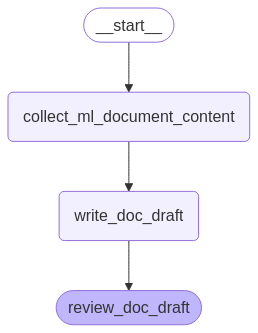

In [7]:
from IPython.display import Image, display

display(Image(auto_ml_doc_flow.get_graph().draw_mermaid_png()))

In [8]:
class LangGraphChatAgent(ChatAgent):
    def __init__(self, agent: CompiledStateGraph):
        self.agent = agent

    def predict(
            self,
            messages: list[ChatAgentMessage],
            context: Optional[ChatContext] = None,
            custom_inputs: Optional[dict[str, Any]] = None,
    ) -> ChatAgentResponse:
        request = {"messages": self._convert_messages_to_dict(messages)}

        if context:
            request["context"] = context

        if custom_inputs:
            request["custom_inputs"] = custom_inputs

        messages = []
        custom_outputs = {}
        for event in self.agent.stream(request, stream_mode="updates"):
            for node_data in event.values():
                messages.extend(
                    ChatAgentMessage(**msg) for msg in node_data.get("messages", [])
                )
                if "custom_outputs" in node_data:
                    custom_outputs.update(node_data["custom_outputs"])

        return ChatAgentResponse(messages=messages, custom_outputs=custom_outputs)

    def predict_stream(
            self,
            messages: list[ChatAgentMessage],
            context: Optional[ChatContext] = None,
            custom_inputs: Optional[dict[str, Any]] = None,
    ) -> Generator[ChatAgentChunk, None, None]:
        request = {"messages": self._convert_messages_to_dict(messages)}

        if context:
            request["context"] = context

        if custom_inputs:
            request["custom_inputs"] = custom_inputs

        for event in self.agent.stream(request, stream_mode="updates"):
            for node_data in event.values():
                yield from (
                    ChatAgentChunk(**{"delta": msg}) for msg in node_data["messages"]
                )


In [9]:
AGENT = LangGraphChatAgent(auto_ml_doc_flow)
mlflow.models.set_model(AGENT)
AGENT.predict(messages={"messages": [{"role": "user", "content": "Create a comprehensive ML document"}]},
              custom_inputs={"catalog": CATALOG, "schema": SCHEMA, "model": model})

AttributeError: 'str' object has no attribute 'model_dump_compat'

In [10]:
AGENT.predict({"messages": [{"role": "user", "content": "Create a comprehensive ML document"}],
              "custom_inputs": {"catalog": CATALOG, "schema": SCHEMA, "model": model}})

RestException: RESOURCE_DOES_NOT_EXIST: Registered Model with name=qyu.dbdemos_fs_travel.dbdemos_fs_travel_model not found

Trace(request_id=25f19ec2b177425c9cd521251ebb4f41)

In [31]:
import mlflow
from databricks_langchain import VectorSearchRetrieverTool
from mlflow.models.resources import DatabricksFunction, DatabricksServingEndpoint
from unitycatalog.ai.langchain.toolkit import UnityCatalogTool


resources = [DatabricksServingEndpoint(endpoint_name=LLM_ENDPOINT_NAME)]
for tool in tools:
    if isinstance(tool, VectorSearchRetrieverTool):
        resources.extend(tool.resources)
    elif isinstance(tool, UnityCatalogTool):
        resources.append(DatabricksFunction(function_name=tool.uc_function_name))


with mlflow.start_run():
    logged_agent_info = mlflow.pyfunc.log_model(
        artifact_path="agent",
        python_model="../src/agent.py",
        pip_requirements=[
            "mlflow",
            "langchain",
            "langgraph<0.3.0",
            "databricks-langchain",
            "unitycatalog-langchain[databricks]",
            "pydantic",
        ],
        resources=resources,
    )

[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True to VectorSearchClient().


2025/03/02 17:42:27 INFO mlflow.pyfunc: Predicting on input example to validate output


[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True to VectorSearchClient().
🏃 View run gentle-donkey-705 at: https://adb-984752964297111.11.azuredatabricks.net/#/experiments/738407902153498034/runs/68035f9acf4647e9b817a65d0328ac96
🧪 View experiment at: https://adb-984752964297111.11.azuredatabricks.net/#/experiments/738407902153498034
